# Load Datasets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# --- FILE IDs for Direct Download ---
TRADER_FILE_ID = '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
SENTIMENT_FILE_ID = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'



# DATA PREPARATION AND CLEANSING

In [2]:
# Function to create the direct download URL from Google Drive File ID
def get_direct_url(file_id):
    return f'https://drive.google.com/uc?export=download&id={file_id}'

print("STEP 1: Loading Dataframes from Google Drive...")
print("=" * 70)


# 1. Load Historical Trader Data (High-Frequency)
trader_url = get_direct_url(TRADER_FILE_ID)
df_trader = pd.read_csv(trader_url)
print(f"Loaded df_trader. Shape: {df_trader.shape}")
print(df_trader.head(5))

STEP 1: Loading Dataframes from Google Drive...
Loaded df_trader. Shape: (211224, 16)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL     

In [3]:
# 2. Load Fear & Greed Index Data (Daily Sentiment)
sentiment_url = get_direct_url(SENTIMENT_FILE_ID)
df_sentiment = pd.read_csv(sentiment_url)
# Rename 'Date' to 'date' to match conceptual names from the instruction
df_sentiment.rename(columns={'Date': 'date'}, inplace=True)
print(f"\nLoaded df_sentiment. Shape: {df_sentiment.shape}")
print(df_sentiment.head(5))



Loaded df_sentiment. Shape: (2644, 4)
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


# Data Formatting

In [4]:
# 1. Convert 'Timestamp' (milliseconds) to datetime
df_trader['Timestamp_DT'] = pd.to_datetime(df_trader['Timestamp'], unit='ms')

# 2. Create a standardized Daily Key (YYYY-MM-DD date object)
df_trader['DateKey'] = df_trader['Timestamp_DT'].dt.normalize().dt.date
df_trader_prepared = df_trader.copy()
print(f"Trader Data Prepared (N={len(df_trader_prepared)}) Head:")
print(df_trader_prepared[['DateKey', 'Closed PnL', 'Size Tokens']].head(5))


# 2B. Prepare Sentiment Lookup Data (df_sentiment_lookup)
# 1. Convert the existing 'date' column to a date object
df_sentiment['DateKey'] = pd.to_datetime(df_sentiment['date']).dt.date

# 2. Select only the necessary columns for the lookup table
df_sentiment_lookup = df_sentiment[['DateKey', 'value', 'classification']].copy()
print(f"\nSentiment Lookup Data (N={len(df_sentiment_lookup)}) Head:")
print(df_sentiment_lookup.head(5))

Trader Data Prepared (N=211224) Head:
      DateKey  Closed PnL  Size Tokens
0  2024-10-27         0.0       986.87
1  2024-10-27         0.0        16.00
2  2024-10-27         0.0       144.09
3  2024-10-27         0.0       142.98
4  2024-10-27         0.0         8.73

Sentiment Lookup Data (N=2644) Head:
      DateKey  value classification
0  2018-02-01     30           Fear
1  2018-02-02     15   Extreme Fear
2  2018-02-03     40           Fear
3  2018-02-04     24   Extreme Fear
4  2018-02-05     11   Extreme Fear


# Merging two dataframes (left merge to keep all observations from trader data)

In [5]:
df_merged_trade_level = pd.merge(
    df_trader_prepared,
    df_sentiment_lookup,
    on='DateKey',
    how='left'
)

df_merged = df_merged_trade_level

# Clean up final DataFrame
df_merged.set_index('Timestamp_DT', inplace=True)
df_merged.drop(columns=['DateKey', 'Timestamp'], inplace=True)

# Remove rows where sentiment could not be linked (NaN sentiment)
df_merged.dropna(subset=['value'], inplace=True)

print(f"\nSuccessfully Merged DataFrame. Final Shape: {df_merged.shape}")
print(df_merged.head(5))



Successfully Merged DataFrame. Final Shape: (184263, 17)
                                                        Account  Coin  \
Timestamp_DT                                                            
2024-10-27 03:33:20  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107   
2024-10-27 03:33:20  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107   
2024-10-27 03:33:20  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107   
2024-10-27 03:33:20  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107   
2024-10-27 03:33:20  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107   

                     Execution Price  Size Tokens  Size USD Side  \
Timestamp_DT                                                       
2024-10-27 03:33:20           7.9769       986.87   7872.16  BUY   
2024-10-27 03:33:20           7.9800        16.00    127.68  BUY   
2024-10-27 03:33:20           7.9855       144.09   1150.63  BUY   
2024-10-27 03:33:20           7.9874       142.98   1142.04  BUY   
2024-10-27 03:33:20   

# Exploratory Data Analysis

In [6]:
numerical_cols = ['Size Tokens', 'Closed PnL', 'value']
correlation_matrix = df_merged[numerical_cols].corr()

print("Correlation of Trading Metrics with Fear & Greed Index (value):")
print(correlation_matrix)

Correlation of Trading Metrics with Fear & Greed Index (value):
             Size Tokens  Closed PnL     value
Size Tokens     1.000000    0.005037  0.035295
Closed PnL      0.005037    1.000000  0.011132
value           0.035295    0.011132  1.000000


### Corerelation of 0.035295 between Volume (Size tokens) and Sentiment (Value) implies that there is an weak positive correlation between variables implying very less effect of sentiment on the volume.

### Corerelation of 0.011132 between PnL and Sentiment (Value) implies that there is too weak positive correlation between variables,Profitability is not linearly tied to Fear and greed.

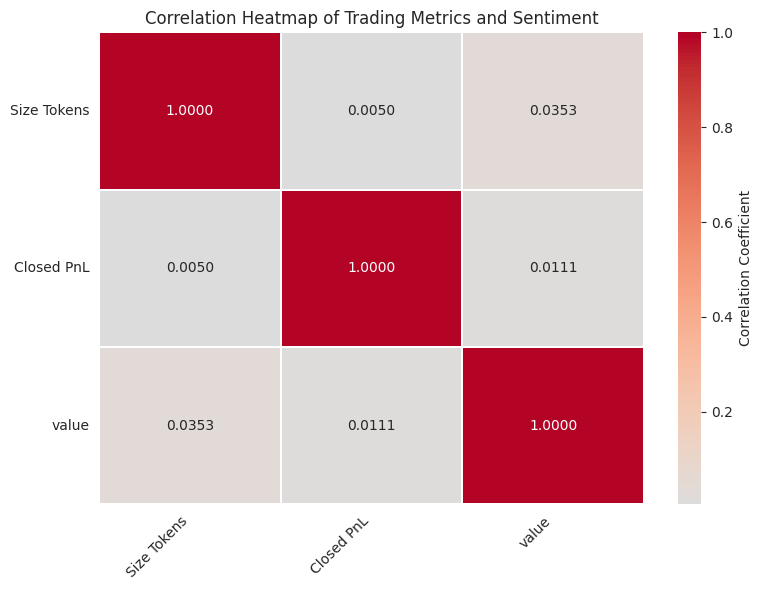

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".4f",
    cmap='coolwarm',
    center=0,
    linewidths=0.2,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap of Trading Metrics and Sentiment')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Calculate the average (mean) trade metrics for each sentiment classification
grouped_analysis = df_merged.groupby('classification').agg(
    # Average Profit per Trade
    Avg_PnL_per_Trade=('Closed PnL', 'mean'),
    # Average Size per Trade
    Avg_Size_per_Trade=('Size Tokens', 'mean'),
    # Total Trades (as a proxy for activity/risk)
    Total_Trades=('Closed PnL', 'count')
).sort_values(by='Avg_PnL_per_Trade', ascending=False)

print("Average Trade Metrics Grouped by Market Sentiment Classification:")
print(grouped_analysis)

Average Trade Metrics Grouped by Market Sentiment Classification:
                Avg_PnL_per_Trade  Avg_Size_per_Trade  Total_Trades
classification                                                     
Greed                   87.894859         2232.117751         36289
Fear                    50.047622         3071.523165        133871
Extreme Greed           25.418772        48736.443323          6962
Neutral                 22.229713         1967.302964          7141


### The highest average profitability per trade is observed during **Greed** Phase with avearge profit of $87.89 per trade

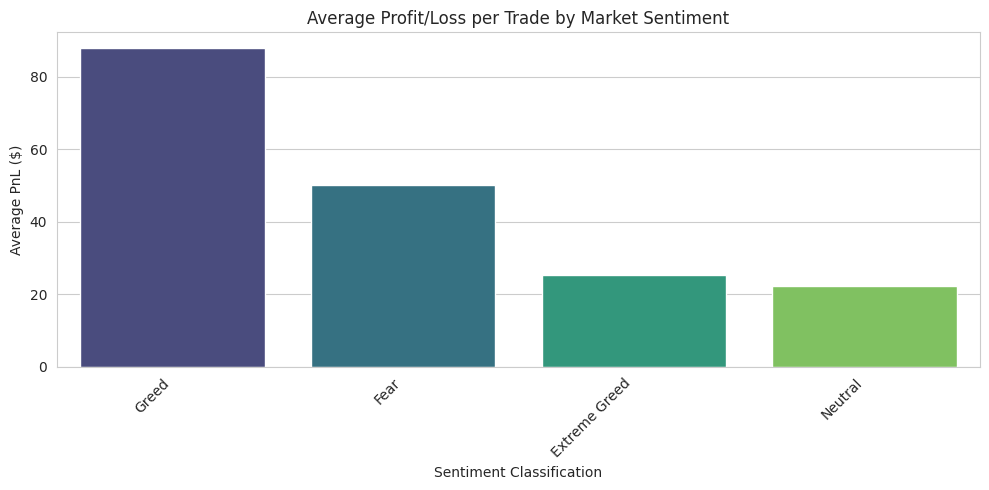

In [9]:
# Visualization 1: Average PnL by Classification
plt.figure(figsize=(10, 5))
sns.barplot(x=grouped_analysis.index, y=grouped_analysis['Avg_PnL_per_Trade'], hue=grouped_analysis.index, palette='viridis', legend=False)
plt.title('Average Profit/Loss per Trade by Market Sentiment')
plt.ylabel('Average PnL ($)')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Thus, traders should prioritize opening trades when sentiment is **Greed** to gain the highest average return as compared to trading during Fear and Extreme Greed

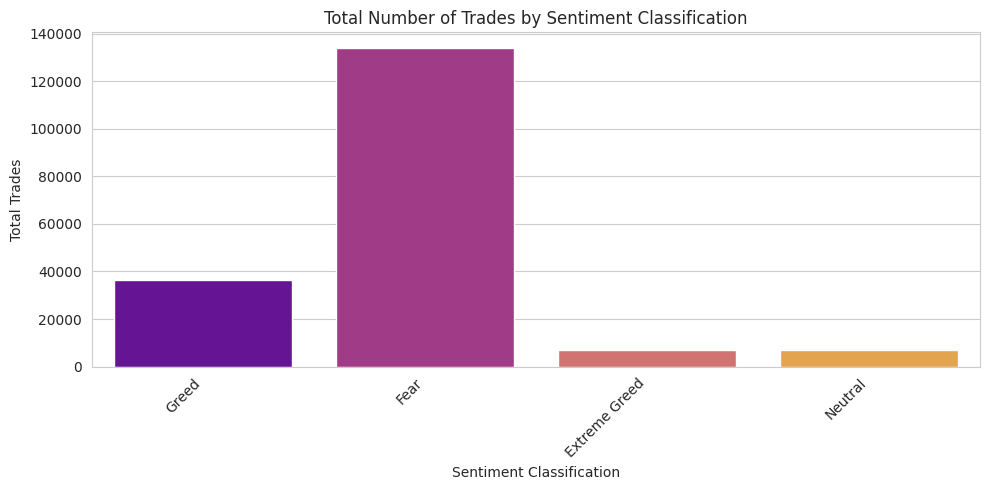

In [10]:
# Visualization 2: Total Trade Count by Classification
plt.figure(figsize=(10, 5))
sns.barplot(x=grouped_analysis.index, y=grouped_analysis['Total_Trades'], hue=grouped_analysis.index, palette='plasma', legend=False)
plt.title('Total Number of Trades by Sentiment Classification')
plt.ylabel('Total Trades')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### The highest trades during the Fear implies that the traders panically selling the trades during this period to minimize the losses

Percentage of BUY vs. SELL Trades by Sentiment:
Side                 BUY      SELL
classification                    
Fear            0.493617  0.506383
Neutral         0.490828  0.509172
Extreme Greed   0.484200  0.515800
Greed           0.424950  0.575050


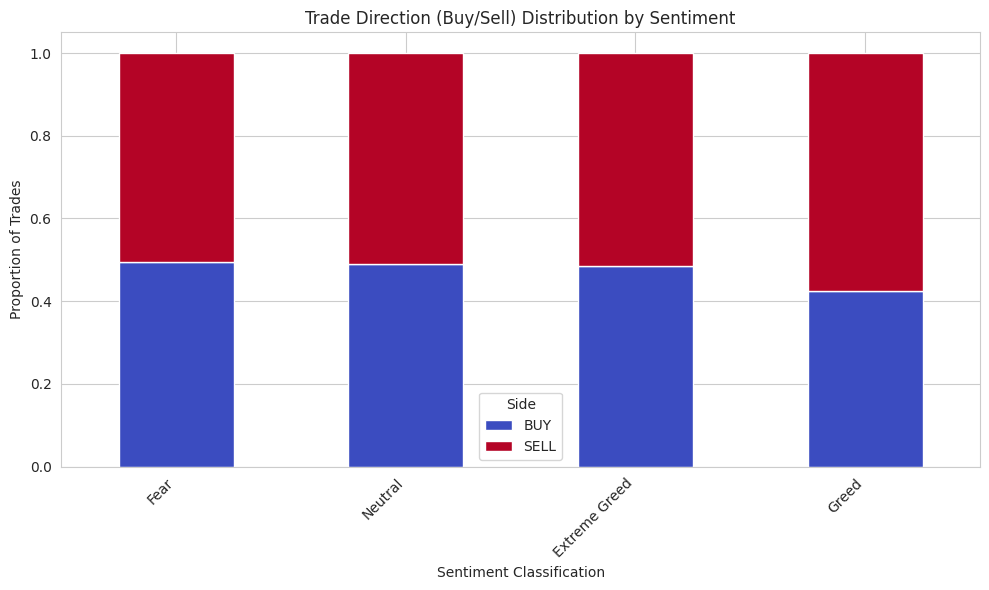

In [11]:
# Pivot the data to count trades by 'Side' within each 'classification'
side_counts = df_merged.groupby(['classification', 'Side']).size().unstack(fill_value=0)

# Calculate the percentage of trades for each side within the sentiment classification
side_percentage = side_counts.apply(lambda x: x / x.sum(), axis=1)
side_percentage = side_percentage[['BUY', 'SELL']].sort_values(by='BUY', ascending=False)

print("Percentage of BUY vs. SELL Trades by Sentiment:")
print(side_percentage)

# Visualization: Stacked Bar Chart of Buy/Sell Ratios
side_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Trade Direction (Buy/Sell) Distribution by Sentiment')
plt.ylabel('Proportion of Trades')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Side')
plt.tight_layout()
plt.show()

### The equal seller and buyer (approximately 0.5) for both fear and extreme greed implies that the traders are equally spread between buying the dip or extreme peak and panic selling

### The bias towards SELL Greed suggests that traders on average, tend to use this period as an profit making period by selling.

Standard Deviation of PnL per Trade by Sentiment (Risk Indicator):
classification
Greed            1148.343968
Fear              909.121796
Neutral           633.704815
Extreme Greed     306.166937
Name: Closed PnL, dtype: float64


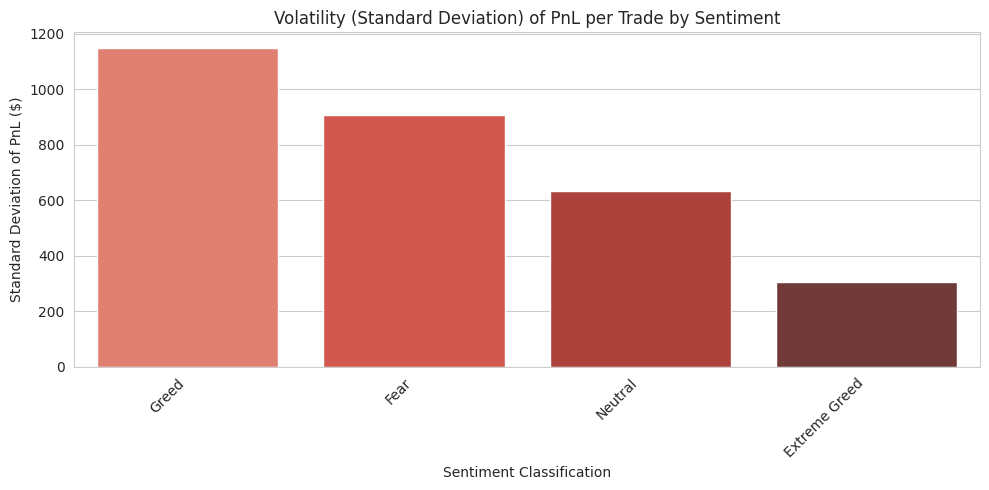

In [12]:
# Calculate the Standard Deviation of Closed PnL for each sentiment classification
pnl_volatility = df_merged.groupby('classification')['Closed PnL'].std().sort_values(ascending=False)

print("Standard Deviation of PnL per Trade by Sentiment (Risk Indicator):")
print(pnl_volatility)

# Visualization
plt.figure(figsize=(10, 5))
# Use the standard fix for Seaborn FutureWarning
sns.barplot(
    x=pnl_volatility.index,
    y=pnl_volatility.values,
    hue=pnl_volatility.index,
    palette='Reds_d',
    legend=False
)
plt.title('Volatility (Standard Deviation) of PnL per Trade by Sentiment')
plt.ylabel('Standard Deviation of PnL ($)')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### The Standard devation for Greed induces the highest trading risk among, resulting in the widest dispersion of PnL outcomes.

### Extreme Greed has lowest standard deviation implying cautious behavior when the market is at extreme peak.


Average PnL per Trade, Grouped by YESTERDAY'S Sentiment:
lagged_classification
Greed            70.211698
Extreme Greed    62.046572
Fear             59.686538
Extreme Fear     52.185226
Neutral          31.346867
Name: Closed PnL, dtype: float64


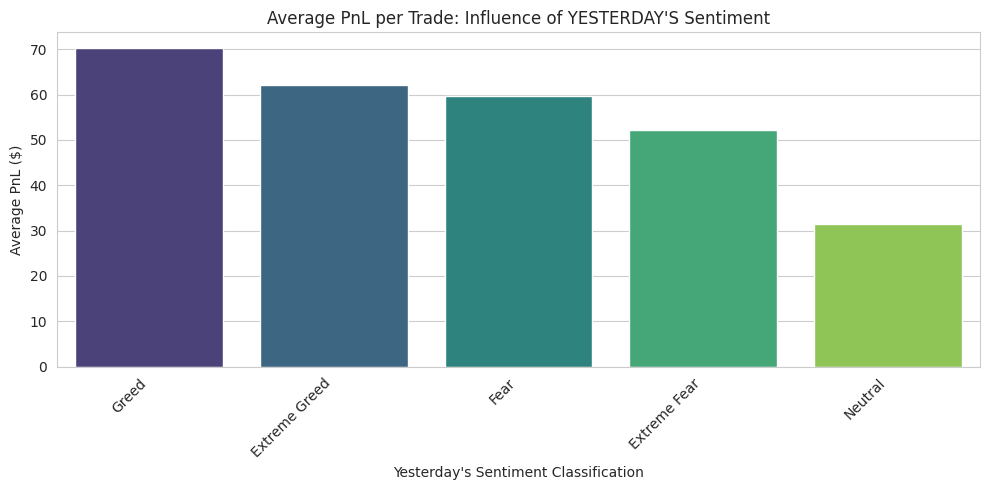

In [13]:

# Set the actual column name from the df_trader/df_merged DataFrame
DAILY_DATE_COLUMN_NAME = 'Timestamp IST'
df_merged.rename(columns={DAILY_DATE_COLUMN_NAME: 'date'}, inplace=True)
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%d-%m-%Y %H:%M', errors='coerce').dt.normalize()


# Prepare the sentiment data for lagging
df_sentiment_lag = df_sentiment[['date', 'classification']].copy()
# Lag the date by one day (T+1 becomes the new join key for T trades)
df_sentiment_lag['lag_date'] = df_sentiment_lag['date'] + pd.Timedelta(days=1)
df_sentiment_lag.rename(columns={'classification': 'lagged_classification'}, inplace=True)

# This aligns today's trades (df_merged.date) with yesterday's sentiment
df_lagged_merged = pd.merge(
    df_merged.copy(),  # Trades executed today
    df_sentiment_lag[['lag_date', 'lagged_classification']],
    left_on='date',
    right_on='lag_date',
    how='left'
)

# Calculate Average PnL based on the lagged sentiment
lagged_pnl = df_lagged_merged.dropna(subset=['lagged_classification']).groupby('lagged_classification')['Closed PnL'].mean().sort_values(ascending=False)

print("\nAverage PnL per Trade, Grouped by YESTERDAY'S Sentiment:")
print(lagged_pnl)

# Visualization of Lagged PnL
plt.figure(figsize=(10, 5))
sns.barplot(
    x=lagged_pnl.index,
    y=lagged_pnl.values,
    hue=lagged_pnl.index,
    palette='viridis',
    legend=False
)
plt.title('Average PnL per Trade: Influence of YESTERDAY\'S Sentiment')
plt.ylabel('Average PnL ($)')
plt.xlabel('Yesterday\'s Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### The highest bars for the yesterdays Greed and extreme greed implies that the todays profit will be higher if the last days (yesterdays) sentiment is greed or extreme greed.

### The day following an neutral day had least profit.

Total Smart Money Accounts (Top 10%): 4

Average PnL per Trade for TOP 10% ACCOUNTS, Grouped by Sentiment:
classification
Greed            140.535750
Fear              60.581438
Neutral           38.092624
Extreme Greed      0.847495
Name: Closed PnL, dtype: float64


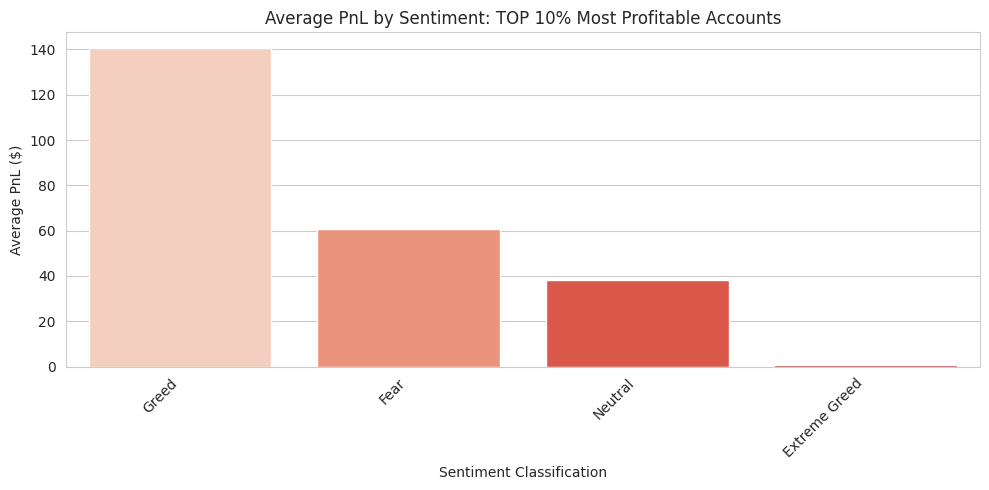

In [14]:
# Calculate Total PnL for each Account
account_pnl = df_merged.groupby('Account')['Closed PnL'].sum()

# Define the threshold for "Smart Money" (Top 10% most profitable accounts)
pnl_threshold = account_pnl.quantile(0.90)
smart_money_accounts = account_pnl[account_pnl >= pnl_threshold].index
df_smart_money = df_merged[df_merged['Account'].isin(smart_money_accounts)].copy()

# Calculate Average PnL for Smart Money accounts by Sentiment
smart_money_pnl = df_smart_money.groupby('classification')['Closed PnL'].mean().sort_values(ascending=False)

print(f"Total Smart Money Accounts (Top 10%): {len(smart_money_accounts)}")
print("\nAverage PnL per Trade for TOP 10% ACCOUNTS, Grouped by Sentiment:")
print(smart_money_pnl)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(
    x=smart_money_pnl.index,
    y=smart_money_pnl.values,
    hue=smart_money_pnl.index,
    palette='Reds',
    legend=False
)
plt.title('Average PnL by Sentiment: TOP 10% Most Profitable Accounts')
plt.ylabel('Average PnL ($)')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### The highest profit are collected during the period of greed where buyer may be taking the profitabe short position.

### The lowest profit for extreme greed period implies buyer are highly inactive or observe the trade closely during this period without booking any profit or loss during this period.


Average PnL per Trade, Grouped by Sentiment and Trade Side (BUY vs. SELL):
Side                  BUY        SELL
classification                       
Extreme Greed   25.578564   25.268770
Fear            58.074630   42.222976
Greed           12.489506  143.617782
Neutral         15.646108   28.576120


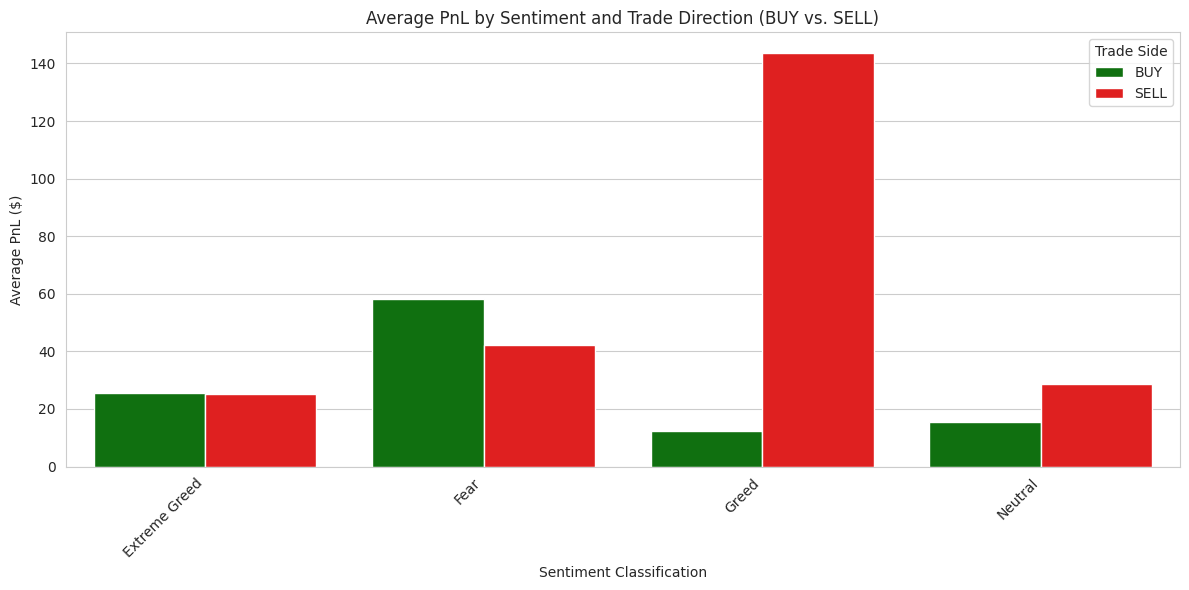

In [15]:
# 1. Calculate Average PnL grouped by both Sentiment AND Trade Side
side_pnl_analysis = df_merged.groupby(['classification', 'Side'])['Closed PnL'].mean().unstack()

print("Average PnL per Trade, Grouped by Sentiment and Trade Side (BUY vs. SELL):")
print(side_pnl_analysis)

# 2. Visualization
# We melt the data for easier plotting with Seaborn
df_plot = side_pnl_analysis.reset_index().melt(
    id_vars='classification',
    value_vars=['BUY', 'SELL'],
    var_name='Trade Side',
    value_name='Average PnL'
)

plt.figure(figsize=(12, 6))
# Using the standard fix for Seaborn FutureWarning
sns.barplot(
    x='classification',
    y='Average PnL',
    hue='Trade Side',
    data=df_plot,
    palette={'BUY': 'green', 'SELL': 'red'}
)
plt.title('Average PnL by Sentiment and Trade Direction (BUY vs. SELL)')
plt.ylabel('Average PnL ($)')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Trade Side')
plt.tight_layout()
plt.show()


### The graph shows the tendency of the buyers with Very high sell bar during the greed and high buying during the period of of fear or dip.

## Warning: The Leverage column in missing in the data, which is required for the further analysis. Please provide the updated data for complete analysis